In [46]:
from pyspark.sql import SparkSession 
spark = SparkSession.builder.appName("Spark_Project").config("spark.sql.shuffle.partitions", "8").config("spark.executor.memory", "2g").getOrCreate()

df = spark.read.csv('data.csv',header=True,inferSchema=True)

In [47]:
spark.version

'4.0.1'

In [48]:
df.printSchema()

root
 |-- RowNumber: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)



In [49]:
df.show(6)

+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId| Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|        1|  15634602|Hargrave|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|
|        2|  15647311|    Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|        3|  15619304|    Onio|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|        4|  15701354|    Boni|        699|   France|Female| 39|     1|      0.0|            2|        0|             0|       93826.63|

In [50]:
df.describe().show()

+-------+------------------+-----------------+-------+-----------------+---------+------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-----------------+-------------------+
|summary|         RowNumber|       CustomerId|Surname|      CreditScore|Geography|Gender|               Age|            Tenure|          Balance|     NumOfProducts|          HasCrCard|     IsActiveMember|  EstimatedSalary|             Exited|
+-------+------------------+-----------------+-------+-----------------+---------+------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-----------------+-------------------+
|  count|             10000|            10000|  10000|            10000|    10000| 10000|             10000|             10000|            10000|             10000|              10000|              10000|            10000|              10000|
|   mean|            5000.5|

In [51]:
from pyspark.sql.functions import col, sum

missing_counts = df.select([
    sum(col(c).isNull().cast("int")).alias(c)
    for c in df.columns
])
missing_counts.show()


+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId|Surname|CreditScore|Geography|Gender|Age|Tenure|Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
|        0|         0|      0|          0|        0|     0|  0|     0|      0|            0|        0|             0|              0|     0|
+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+



IQR = 120.0, Thresholds: [408.0, 888.0]
Nombre d'outliers for column CreditScore: 24


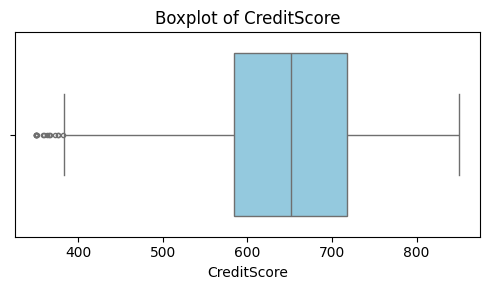

##################################################
IQR = 11.0, Thresholds: [15.5, 59.5]
Nombre d'outliers for column Age: 526


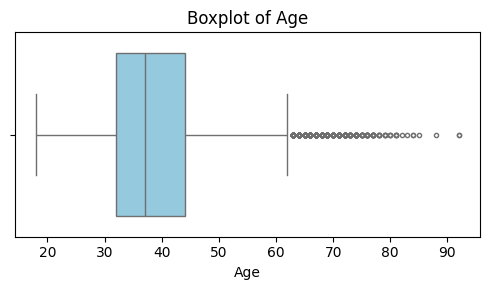

##################################################
IQR = 4.0, Thresholds: [-3.0, 13.0]
Nombre d'outliers for column Tenure: 0


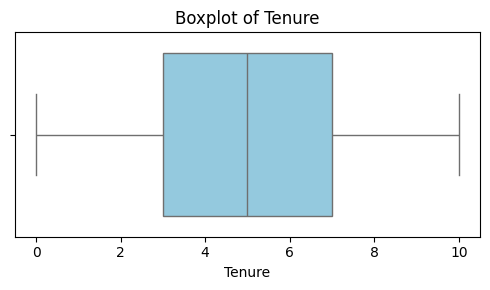

##################################################
IQR = 123835.52, Thresholds: [-185753.28, 309588.8]
Nombre d'outliers for column Balance: 0


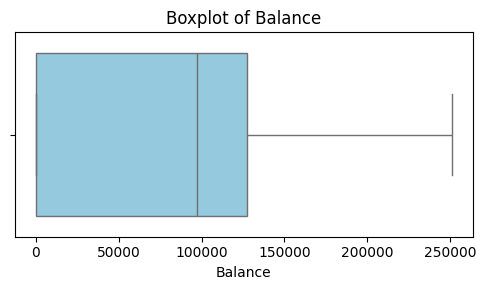

##################################################
IQR = 1.0, Thresholds: [-0.5, 3.5]
Nombre d'outliers for column NumOfProducts: 60


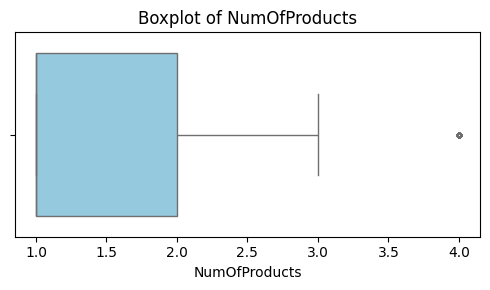

##################################################
IQR = 88670.6, Thresholds: [-78892.52000000002, 275789.88]
Nombre d'outliers for column EstimatedSalary: 0


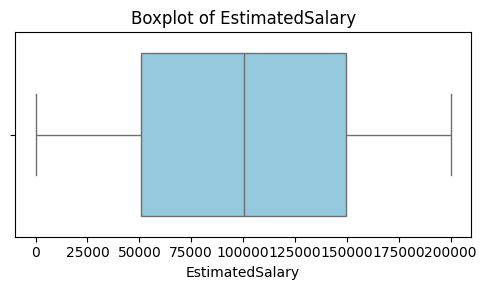

##################################################


In [52]:
from pyspark.sql.functions import col
from pyspark.sql.types import NumericType
import matplotlib.pyplot as plt
import seaborn as sns



skipped_columns = ["RowNumber", "CustomerId", "Exited", "HasCrCard", "IsActiveMember"]

for c in df.columns:
    if not isinstance(df.schema[c].dataType, NumericType) or c in skipped_columns:
        continue

    quantiles = df.approxQuantile(c, [0.25, 0.75], 0.05)
    Q1, Q3 = quantiles
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"IQR = {IQR}, Thresholds: [{lower_bound}, {upper_bound}]")

    outliers = df.filter((col(c) < lower_bound) | (col(c) > upper_bound))
    outlier_count = outliers.count()
    print(f"Nombre d'outliers for column {c}: {outlier_count}")
  
    sample_pd = df.select(c).toPandas()

    plt.figure(figsize=(5, 3))
    sns.boxplot(x=sample_pd[c], color="skyblue", fliersize=3)
    plt.title(f"Boxplot of {c}")
    plt.xlabel(c)
    plt.tight_layout()
    plt.show()

    print('#' * 50)

In [53]:
df.filter(df["Age"] > 85).count()

3

In [54]:
df = df.filter(
    (col("CreditScore") >= lower_bound) &
    (col("CreditScore") <= upper_bound) &
    (col("Age") <= 85)
)

In [55]:

df.groupBy('Gender').agg({"Age" : "avg"}).show()


+------+------------------+
|Gender|          avg(Age)|
+------+------------------+
|Female|39.238388729914156|
|  Male|38.629629629629626|
+------+------------------+



In [56]:
df = df.drop("RowNumber","Surname")


In [57]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

indexer_geo = StringIndexer(inputCol="Geography", outputCol="GeographyIndex")
indexer_gender = StringIndexer(inputCol="Gender", outputCol="GenderIndex")

encoder = OneHotEncoder(
    inputCols=["GeographyIndex", "GenderIndex"],
    outputCols=["GeographyVec", "GenderVec"]
)

from pyspark.ml import Pipeline

encoding_pipeline = Pipeline(stages=[indexer_geo, indexer_gender, encoder])
df_encoded = encoding_pipeline.fit(df).transform(df)

df_encoded = df_encoded.drop("Geography", "Gender","GeographyIndex", "GenderIndex")


df_encoded.show(4)

+----------+-----------+---+------+--------+-------------+---------+--------------+---------------+------+-------------+---------+
|CustomerId|CreditScore|Age|Tenure| Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited| GeographyVec|GenderVec|
+----------+-----------+---+------+--------+-------------+---------+--------------+---------------+------+-------------+---------+
|  15634602|        619| 42|     2|     0.0|            1|        1|             1|      101348.88|     1|(2,[0],[1.0])|(1,[],[])|
|  15647311|        608| 41|     1|83807.86|            1|        0|             1|      112542.58|     0|    (2,[],[])|(1,[],[])|
|  15619304|        502| 42|     8|159660.8|            3|        1|             0|      113931.57|     1|(2,[0],[1.0])|(1,[],[])|
|  15701354|        699| 39|     1|     0.0|            2|        0|             0|       93826.63|     0|(2,[0],[1.0])|(1,[],[])|
+----------+-----------+---+------+--------+-------------+---------+--------------+

In [61]:
from pyspark.ml.linalg import SparseVector


df_pd = df_encoded.toPandas()

sparse_cols = ["GenderVec", "GeographyVec"]

for col in sparse_cols:
    df_pd[col] = df_pd[col].apply(lambda x: x.toArray().tolist() if isinstance(x, SparseVector) else x)


records = df_pd.to_dict("records")

In [62]:
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017/") 
db = client["bank_churn_db"]
collection = db["preprocessed_customers"]

collection.insert_many(records)

InsertManyResult([ObjectId('690f59dadf95339139e38d3e'), ObjectId('690f59dadf95339139e38d3f'), ObjectId('690f59dadf95339139e38d40'), ObjectId('690f59dadf95339139e38d41'), ObjectId('690f59dadf95339139e38d42'), ObjectId('690f59dadf95339139e38d43'), ObjectId('690f59dadf95339139e38d44'), ObjectId('690f59dadf95339139e38d45'), ObjectId('690f59dadf95339139e38d46'), ObjectId('690f59dadf95339139e38d47'), ObjectId('690f59dadf95339139e38d48'), ObjectId('690f59dadf95339139e38d49'), ObjectId('690f59dadf95339139e38d4a'), ObjectId('690f59dadf95339139e38d4b'), ObjectId('690f59dadf95339139e38d4c'), ObjectId('690f59dadf95339139e38d4d'), ObjectId('690f59dadf95339139e38d4e'), ObjectId('690f59dadf95339139e38d4f'), ObjectId('690f59dadf95339139e38d50'), ObjectId('690f59dadf95339139e38d51'), ObjectId('690f59dadf95339139e38d52'), ObjectId('690f59dadf95339139e38d53'), ObjectId('690f59dadf95339139e38d54'), ObjectId('690f59dadf95339139e38d55'), ObjectId('690f59dadf95339139e38d56'), ObjectId('690f59dadf95339139e38d

In [65]:
df_encoded = df_encoded.drop("CustomerId")

In [66]:
from pyspark.sql.functions import col

df_minority = df_encoded.filter(col("Exited") == 1)
df_majority = df_encoded.filter(col("Exited") == 0)

df_majority_sampled = df_majority.sample(withReplacement=False, fraction=df_minority.count()/df_majority.count(), seed=42)

df_balanced = df_minority.union(df_majority_sampled)


In [67]:
from pyspark.ml.feature import VectorAssembler

feature_cols = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts",
                "HasCrCard", "IsActiveMember", "EstimatedSalary",
                "GenderVec", "GeographyVec"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")


In [68]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")


train_df, test_df = df_balanced.randomSplit([0.8, 0.2], seed=42)


In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(
    featuresCol="scaledFeatures",  
    labelCol="Exited",
    numTrees=100,                  
    maxDepth=5,                    
    seed=42
)

pipeline = Pipeline(stages=[assembler, scaler, rf])

model = pipeline.fit(train_df)
predictions = model.transform(test_df)